In [82]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F

from laplace import Laplace
import matplotlib.pyplot as plt
from tqdm import tqdm

#os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
os.chdir('g:\\Mi unidad\\MsC_UE\\Dissertation\\Pytorch')

# MNIST Dataset
from MNIST_Models.MNIST_MODELS import LeNet5
from MNIST_Models.MNIST_Data import data_loader

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [83]:
def get_brier_score(probs, targets):
    targets = F.one_hot(targets, num_classes=probs.shape[1])
    return torch.mean(torch.sum((probs - targets)**2, axis=1)).item()

In [84]:
def get_calib(pys, y_true, M=100):
    pys, y_true = pys.cpu().numpy(), y_true.cpu().numpy()
    # Put the confidence into M bins
    _, bins = np.histogram(pys, M, range=(0, 1))

    labels = pys.argmax(1)
    confs = np.max(pys, axis=1)
    conf_idxs = np.digitize(confs, bins)

    # Accuracy and avg. confidence per bin
    accs_bin = []
    confs_bin = []
    nitems_bin = []

    for i in range(M):
        labels_i = labels[conf_idxs == i]
        y_true_i = y_true[conf_idxs == i]
        confs_i = confs[conf_idxs == i]

        acc = np.nan_to_num(np.mean(labels_i == y_true_i), 0)
        conf = np.nan_to_num(np.mean(confs_i), 0)

        accs_bin.append(acc)
        confs_bin.append(conf)
        nitems_bin.append(len(labels_i))

    accs_bin, confs_bin = np.array(accs_bin), np.array(confs_bin)
    nitems_bin = np.array(nitems_bin)

    ECE = np.average(np.abs(confs_bin-accs_bin), weights=nitems_bin/nitems_bin.sum())
    MCE = np.max(np.abs(accs_bin - confs_bin))


    return ECE, MCE,confs_bin,accs_bin,nitems_bin.sum()

In [85]:
n_models = 1
ECE_ = {"Diag":{},"Kron":{},"MAP":{}}
#NLL_ = {"Diag":{},"Kron":{},"MAP":{}}
#BRI_ = {"Diag":{},"Kron":{},"MAP":{}}

loss_fn = torch.nn.CrossEntropyLoss()

pi = torch.ones(n_models, device=device) / n_models

In [86]:
file_models = [os.path.join(os.getcwd(),"MNIST_Models",str(0)+"d","MNIST_m"+str(n + 1)+".pth") for n in range(5)]

models = [LeNet5().to(device) for _ in range(n_models)]

train_dataloader, test_dataloader = data_loader(0,120)

for file, model in zip(file_models,models):
    model.load_state_dict(torch.load(file))
    model.eval()

LLA_D = []
LLA_K = []

for model in models:
### Laplace Approximation Diagonal
    la = Laplace(model, 'classification',
                subset_of_weights='last_layer',
                hessian_structure='diag')
        
    la.fit(train_dataloader)
    la.optimize_prior_precision(method='marglik',
                pred_type = "glm",
                link_approx = "probit",
                n_samples = 100)
    LLA_D.append(la)

### Laplace Approximation Kronocker Factor...
    la = Laplace(model, 'classification',
                subset_of_weights='last_layer',
                hessian_structure='kron')
        
    la.fit(train_dataloader)
    la.optimize_prior_precision(method='marglik',
                pred_type = "glm",
                link_approx = "probit",
                n_samples = 100)
    LLA_K.append(la)

In [87]:
models = models[0]
LLA_K_ = LLA_K[0]
LLA_D = LLA_D[0]

In [88]:
#for angle in range(0,161,10):

train_dataloader, test_dataloader = data_loader(0,120)

all_y_true = list()
all_y_prob_D = list()
all_y_prob_K = list()
all_y_prob_MAP = list()

for (X,y) in test_dataloader:

    X , y = X.to(device), y.to(device)
    
    y_pred_MAP = models(X)

    y_pred_K = LLA_K_(X)

    y_pred_D = LLA_D(X)


    all_y_true.append(y.cpu())

    all_y_prob_MAP.append(y_pred_MAP.cpu().detach())
    all_y_prob_K.append(y_pred_K.cpu())
    all_y_prob_D.append(y_pred_D.cpu())

all_y_prob_MAP = torch.cat(all_y_prob_MAP, dim=0)
all_y_prob_K = torch.cat(all_y_prob_K, dim=0)
all_y_prob_D = torch.cat(all_y_prob_D, dim=0)

all_y_true = torch.cat(all_y_true, dim=0)

ECE_["Kron"][str(0)] = get_calib(all_y_prob_K,all_y_true)
ECE_["MAP"][str(0)] = get_calib(all_y_prob_MAP,all_y_true)
ECE_["Diag"][str(0)] = get_calib(all_y_prob_D,all_y_true)



d:\Users\chris\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Users\chris\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
d:\Users\chris\anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\chris\AppData\Local\Temp/ipykernel_13444/294353296.py:30: RuntimeWarning: invalid value encountered in true_divide
  ECE = np.average(np.abs(confs_bin-accs_bin), weights=nitems_bin/nitems_bin.sum())


In [89]:
# ECE_K = pd.DataFrame.from_dict(ECE_["Kron"]).T
# ECE_MAP = pd.DataFrame.from_dict(ECE_["MAP"]).T

In [90]:
ece = ECE_["Kron"]["0"][3]/ECE_["Kron"]["0"][4]
ece2 = ECE_["Diag"]["0"][3]/ECE_["Kron"]["0"][4]

In [91]:
ece = ece[ece!=0]
ece2 = ece2[ece2!=0]

In [96]:
ECE_["Kron"]["0"][4]

1092

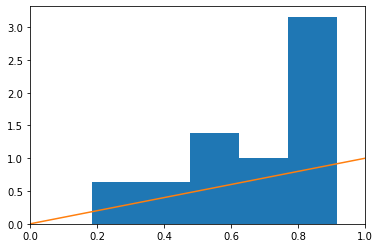

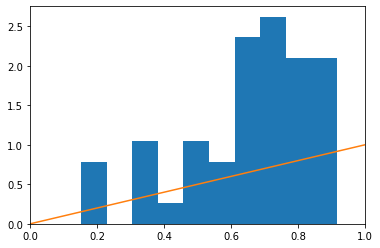

In [99]:

plt.hist(ece*1000, density=True,cumulative=False,bins=5)
plt.plot([0,1],[0,1])
plt.xlim([0,1])
#plt.ylim([0,1])

plt.show()


plt.hist(ece2*1000, density=True,cumulative=False)
plt.plot([0,1],[0,1])
plt.xlim([0,1])
#plt.ylim([0,1])

plt.show()

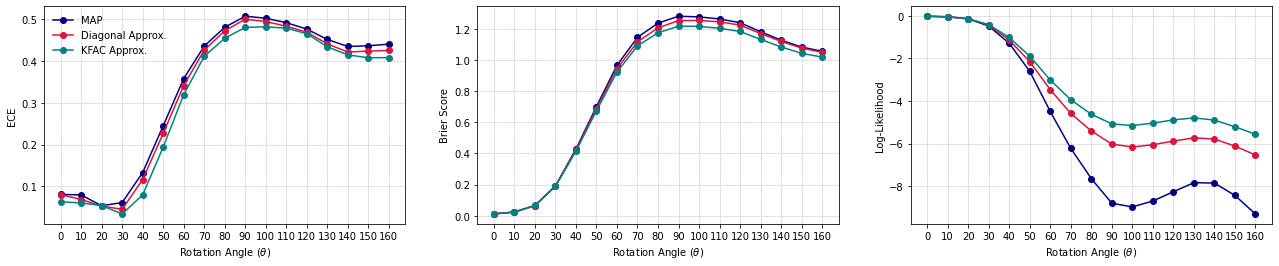

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(22, 4))

axs[0].plot(ECE_MAP[0],'-o',label = "MAP", color = "navy")
axs[0].plot(ECE_D[0],'-o',label = "Diagonal Approx.", color = "crimson")
axs[0].plot(ECE_K[0],'-o',label = "KFAC Approx.", color = "teal")


axs[0].set_xlabel(r"Rotation Angle ($\theta$)")
axs[0].set_ylabel(r"ECE")

axs[0].legend(frameon=False)
axs[0].grid(True,linestyle = '--', linewidth = 0.5)


axs[1].plot(BRI_MAP,'-o',label = "MAP", color = "navy")
axs[1].plot(BRI_D,'-o',label = "Diagonal Approx.", color = "crimson")
axs[1].plot(BRI_K,'-o',label = "KFAC Approx.", color = "teal")

axs[1].set_xlabel(r"Rotation Angle ($\theta$)")
axs[1].set_ylabel(r"Brier Score")

#axs[1].legend(frameon=False)
axs[1].grid(True,linestyle = '--', linewidth = 0.5)



axs[2].plot(-NLL_MAP,'-o',label = "MAP", color = "navy")
axs[2].plot(-NLL_D,'-o',label = "Diagonal Approx.", color = "crimson")
axs[2].plot(-NLL_K,'-o',label = "KFAC Approx.", color = "teal")

axs[2].set_xlabel(r"Rotation Angle ($\theta$)")
axs[2].set_ylabel(r"Log-Likelihood")

#axs[1].legend(frameon=False)
axs[2].grid(True,linestyle = '--', linewidth = 0.5)